# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities by sampling from the data.
* Generate mock TFR distances.

Here, we fit the TFR in bins of $z$ (as our "clusters").

In [1]:
import os
import shutil
import h5py
import fitsio
import pickle
import healpy as hp
import pandas as pd
import numpy as np
import scipy as sp

from itertools import groupby

from csaps import csaps
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc

sys.path.append('/global/u1/k/kadglass/DESI_SGA/TF/')
from hyperfit.linfit import LinFit
from hyperfit_v2 import MultiLinFit
from line_fits import hyperfit_line_multi

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from tqdm import tqdm
from glob import glob

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [3]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [4]:
#- Drop NaN
iron = iron.dropna()
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [5]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [6]:
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [7]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [8]:
#- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
select = iron['z'] > 0

kc = tfpc.k_corr(iron['z'][select], 
                [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
                [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
                z_corr=0.1)

Ak = np.zeros((len(iron), 3))
Ak[select] = kc

### MW Dust Correction

In [9]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [10]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys + Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.37475514  0.75256222]
uncertainty:  [0.08632504 0.04738354]


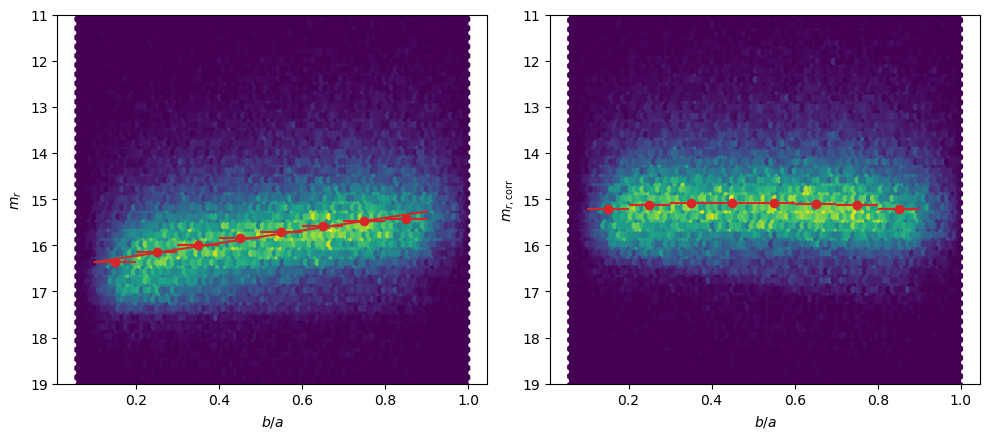

In [11]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'])
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [20]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
n_mock = len(mockfiles)
# mockfile = mockfiles[0]
# mockfile = mockfiles[np.random.randint(n_mock)]
mockfile = os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base_c000_ph000_r001_z0.11.dat.hdf5')

print(f'Picked mock file {os.path.basename(mockfile)}.')

Picked mock file BGS_PV_AbacusSummit_base_c000_ph000_r001_z0.11.dat.hdf5.


In [21]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [22]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [23]:
mock

Y1_COMP   Y3_COMP    Y5    abs_mag    app_mag       col   col_obs  \
0       1.000000  0.991803  True -21.603735  16.064020  0.973818  1.000261   
1       0.000000  0.962963  True -22.974319  14.690473  0.943890  0.969189   
2       1.000000  1.000000  True -20.328584  17.335948  0.754470  0.772327   
3       0.992857  0.992857  True -22.095708  15.565224  0.963012  0.988384   
4       1.000000  1.000000  True -20.940196  16.710539  0.752585  0.769231   
...          ...       ...   ...        ...        ...       ...       ...   
460957  0.845070  0.964789  True -20.442594  17.215514  1.041612  1.067414   
460958  0.993506  1.000000  True -20.977689  16.686527  0.941542  0.966701   
460959  0.609023  0.969925  True -21.044177  16.615062  0.952042  0.976926   
460960  0.958333  1.000000  True -21.492587  16.173641  1.003167  1.029903   
460961  0.886905  0.994048  True -19.926223  17.697176  0.774154  0.789158   

             dec     halo_mass  healpix  ...  Z_MAG_SB26_ERR  photsys  \
0      -0.999080  6.546589e+12    11943  ...        0.020302        N   
1       4.955850  1.250601e+14    19362  ...        0.017098        S   
2       4.141360  1.098831e+12     9063  ...        0.040119        S   
3      -2.295285  3.791707e+13     8866  ...        0.005774        S   
4      -2.161120  3.737292e+12    19996  ...        0.010283        S   
...          ...           ...      ...  ...             ...      ...   
460957  1.054418  1.092504e+12    11953  ...        0.050015        N   
460958 -5.495919  2.952714e+12    27655  ...        0.012371        S   
460959  1.892966  4.370017e+12    27655  ...        0.012371        S   
460960 -2.016671  1.960813e+13    25531  ...        0.013396        S   
460961  1.138406  8.054793e+13     8796  ...        0.035210        S   

       G_MAG_SB26_tmp  G_MAG_SB26_ERR_tmp R_MAG_SB26_tmp  R_MAG_SB26_ERR_tmp  \
0           16.836736            0.037406      15.854162            0.031360   
1           15.576678            0.038922      14.651459            0.027936   
2           17.698509            0.047886      16.911085            0.042496   
3           16.485955            0.026155      15.494399            0.018091   
4           17.428144                 NaN      16.809270                 NaN   
...               ...                 ...            ...                 ...   
460957      17.797096            0.047117      16.751333            0.048677   
460958      17.540445            0.025481      16.560813            0.019910   
460959      17.540445            0.025481      16.560813            0.019910   
460960      17.045383            0.032928      16.025221            0.024078   
460961      17.911914            0.044089      17.107244            0.039024   

        Z_MAG_SB26_tmp  Z_MAG_SB26_ERR_tmp  R_MAG_SB26_CORR  \
0            15.381491            0.030668        15.524017   
1            14.005386            0.022183        14.201208   
2            16.283822            0.041635        15.838278   
3            14.805653            0.011323        15.381549   
4            16.361631                 NaN        16.666891   
...                ...                 ...              ...   
460957       15.985596            0.054987        15.699726   
460958       15.957129            0.015125        16.226617   
460959       15.957129            0.015125        16.226617   
460960       15.330357            0.017762        15.912114   
460961       16.519934            0.036990        16.029573   

        R_MAG_SB26_ERR_CORR  
0                  0.037593  
1                  0.039746  
2                  0.079649  
3                  0.019429  
4                       NaN  
...                     ...  
460957             0.082036  
460958             0.028927  
460959             0.028927  
460960             0.025104  
460961             0.078116  

[460962 rows x 61 columns]

### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [24]:
mock_selection = {
    'basic cuts' : 0,
    # 'z < 0.1' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
# select = mock['zobs'] <= 0.105
# mock = mock[select]
# mock_selection['z < 0.1'] = len(mock)
# print(f'Redshift selection: z < 0.1 {len(mock):.>29d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................460962
Size after photometric cuts .......................460765
Ratio b/a < cos(25 deg) ...........................445228
Morphology cuts: ..................................237495
Drop NaN ..........................................203127


/tmp/ipykernel_1832447/1003090540.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


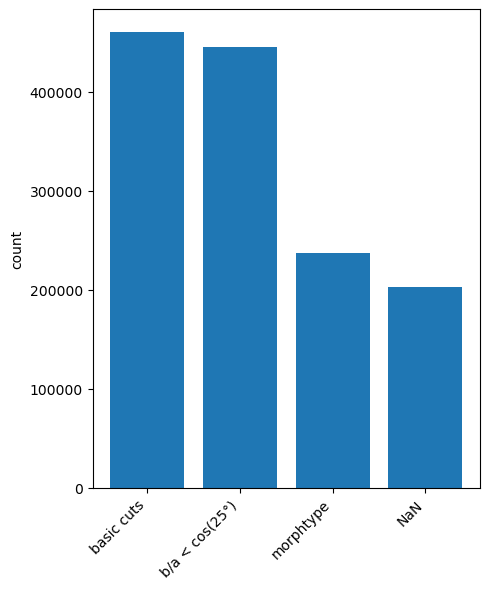

In [25]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [26]:
h = 1

cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v8 of the TF Y1 catalog. This comes from the TFR calibration using redshift bins of width $dz = 0.005$ for galaxies with $0.03 < z < 0.1$ using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_zbin_calibration_weightsVmax-1_cutsAlex_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, redshift-bin zero points $b_i$ (in apparent magnitude space), and intrinsic scatter $\sigma$.

In [27]:
with open('../cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_KAD-20250810.pickle', 'rb') as tfr_file:
    tf_cov, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

# Store TF best-fit parameters.
tf_par = np.median(tfr_samples, axis=1)
a = tf_par[0]
sigma = tf_par[-1]
b = tf_par[1:-1]

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [28]:
tfr_version = 'v13'

tfrcatfile = os.path.join(pvpath, f'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_{tfr_version}.fits')
tfrcat = Table.read(tfrcatfile)

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_ERR', 'MAIN', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err'].to_pandas()
tfrcat

Z_DESI       D26  R_MAG_SB26_CORR  R_MAG_SB26_ERR_CORR  \
0      0.080990  0.417579        16.728902             0.109794   
1      0.044002  0.495681        16.876765             0.087894   
2      0.090040  0.567250        15.954404             0.113037   
3      0.034026  0.575771        16.643692             0.098862   
4      0.043319  0.953031        15.209917             0.143845   
...         ...       ...              ...                  ...   
10257  0.116921  0.369286        16.646515             0.078975   
10258  0.054449  0.376227        17.162410             0.045130   
10259  0.118856  0.362001        17.637089             0.071668   
10260  0.133822  0.454465        17.365721             0.139803   
10261  0.056664  0.569711        16.541406             0.113007   

       R_ABSMAG_SB26  R_ABSMAG_SB26_ERR   MAIN    MU_ZCMB  MU_ZCMB_ERR  \
0         -20.342313           0.109796   True  37.071215     0.000657   
1         -18.849995           0.087903   True  35.726760     0.001281   
2         -21.371783           0.113041   True  37.326188     0.000947   
3         -18.507775           0.098876   True  35.151467     0.001645   
4         -20.465532           0.143851   True  35.675450     0.001324   
...              ...                ...    ...        ...          ...   
10257     -21.259350           0.078976   True  37.905865     0.000473   
10258     -18.999271           0.045143  False  36.161681     0.001059   
10259     -20.309387           0.071677  False  37.946476     0.001125   
10260     -20.858150           0.139805  False  38.223871     0.000688   
10261     -19.706939           0.113013   True  36.248345     0.001111   

         V_0p4R26  V_0p4R26_ERR  logv_rot  logv_rot_err  
0      122.322389      9.671537  2.087506      0.034315  
1       81.378913      7.725162  1.910512      0.041199  
2      180.655732     12.555108  2.256852      0.030162  
3       70.102004     10.559548  1.845730      0.065374  
4      133.778521     10.574320  2.126386      0.034305  
...           ...           ...       ...           ...  
10257   95.032991      9.304353  1.977874      0.042491  
10258   44.540699     10.167579  1.648757      0.099072  
10259  123.942595     17.891204  2.093221      0.062648  
10260  172.888238     18.357452  2.237765      0.046083  
10261   78.660236     11.389903  1.895755      0.062843  

[10262 rows x 13 columns]

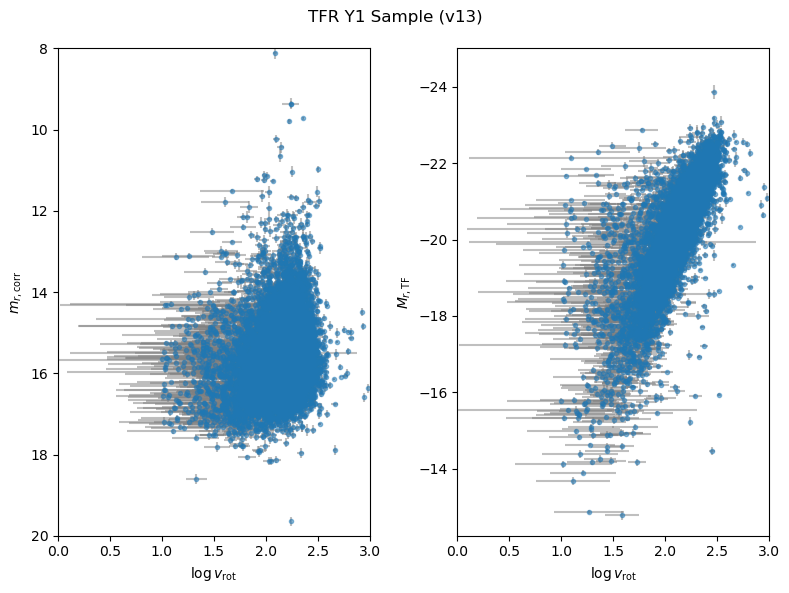

In [29]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle(f'TFR Y1 Sample ({tfr_version})');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
2. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
3. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
4. Sample $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude, computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling a value for each mock galaxy.

In [30]:
#- 1. distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
Mr_cos_mock = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- 2. Compute an observed magnitude based on the PVs in the mock catalog.
mu_obs_mock = cosmology.distmod(mock['zobs']).to_value('mag')
mock['MU_OBS_MOCK'] = mu_obs_mock
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - mu_obs_mock).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and generate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.zeros(len(Mr_cos_mock))

use_weighted_fit = True

for k in tqdm(np.arange(0, N_bins-1)):
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()

    if use_weighted_fit:
        #-Attempt to built a weighted CDF
        logvrot_bins = np.arange(1, 3.01, 0.01)
        logvrot_pdf_wt, logv_bins = np.histogram(logvrot_slice, bins=logvrot_bins, 
                                                 weights=np.ones_like(logvrot_err_slice)
                                                 # weights=1/logvrot_err_slice**2
                                                )
        logvrot_cdf = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
        
        logvrot_slice = 0.5*(logvrot_bins[1:] + logvrot_bins[:-1])

        #- Keep only the unique elements in the list
        idx = np.cumsum([len(list(g)) for k, g in groupby(logvrot_cdf)])[:-1]
        logvrot_cdf = logvrot_cdf[idx]
        logvrot_slice = logvrot_slice[idx]
        # print(logvrot_cdf.shape, logvrot_slice.shape)
    else:
        #- Default to use the unweighted CDF
        logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    # j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    j = (Mr_cos_mock > M_r_min) & (Mr_cos_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 10 to 1000 km/s.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
        # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])

# #- Next, scatter in the Mr_obs, logvrot plane using the sigma fit from the data,
# #  projected onto the best fit line in the TFR Y1 *data*. Use this projected sigma
# #  to scatter the mock Mr_obs vs logvrot.
# slope = np.asarray([-a, 1.])
# slope = slope / np.sqrt(np.dot(slope, slope))

# logging.warning('Using a fudge factor in sigma. Revisit!')
# scale = np.random.normal(0, 0.13*sigma, len(Mr_obs))
# logvrot_mock = logvrot + scale*slope[0]
# Mr_obs_mock = Mr_obs + scale*slope[1]

#- Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 68,  56,  55,  77,  95,  71,  57,  67,  82, 101, 112, 119, 120,
       142, 170, 145, 163, 160, 170, 160, 175, 196, 173, 202, 208, 198,
       188, 176, 183, 202, 175, 174, 184, 209, 178, 164, 163, 162, 175,
       163, 153, 152, 170, 150, 153, 137, 131, 142, 124, 106, 122, 124,
       102, 126,  97, 111,  92,  89,  92,  93,  91, 100,  86,  77,  63,
        67,  71,  53,  59,  55,  53,  99,  66,  51,  96,  86,  82,  64,
        60,  68,  59,  57,  61,  51,  57,  56,  52,  51,  51,  16]), array([-26.  , -22.5 , -22.35, -22.25, -22.15, -22.05, -22.  , -21.95,
       -21.9 , -21.85, -21.8 , -21.75, -21.7 , -21.65, -21.6 , -21.55,
       -21.5 , -21.45, -21.4 , -21.35, -21.3 , -21.25, -21.2 , -21.15,
       -21.1 , -21.05, -21.  , -20.95, -20.9 , -20.85, -20.8 , -20.75,
       -20.7 , -20.65, -20.6 , -20.55, -20.5 , -20.45, -20.4 , -20.35,
       -20.3 , -20.25, -20.2 , -20.15, -20.1 , -20.05, -20.  , -19.95,
       -19.9 , -19.85, -19.8 , -19.75, -19.7 , -19.65, -19.6 , -19.55,
 

100%|██████████| 90/90 [00:00<00:00, 284.22it/s]


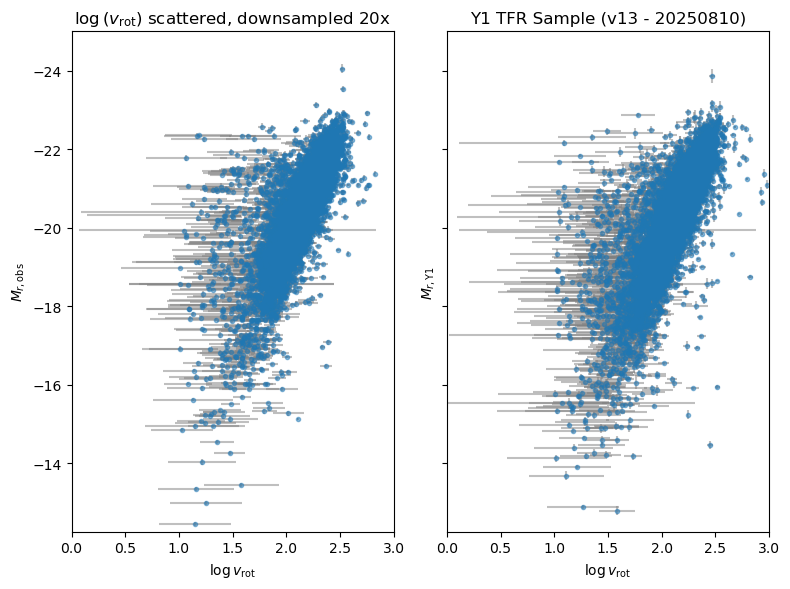

In [32]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.errorbar(
            mock['LOGVROT_MOCK'][::20], mock['R_ABSMAG_SB26_MOCK'][::20],
            xerr=mock['LOGVROT_ERR_MOCK'][::20],
            yerr=mock['R_ABSMAG_SB26_ERR_MOCK'][::20],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$\log{(v_\mathrm{rot})}$ scattered, downsampled 20x')

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title='Y1 TFR Sample (v13 - 20250810)');

# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

### Compute the Maximum Volume for each Galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [33]:
dist = cosmology.luminosity_distance(np.abs(mock['zobs']))
dist_max = cosmology.luminosity_distance(z=0.1)
d26_kpc = 2*dist.to('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
mock_dist_max = 0.5*d26_kpc / np.tan(0.1*u.arcmin)
# surv_max = cosmology.luminosity_distance(z=0.2)

# mock['D26_kpc'] = 2*dist.to_value('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
# mock['DIST_MAX'] = 0.5*mock['D26_kpc'].values / np.tan(0.1*u.arcmin)
# mock['MAX_VOL_FRAC'] = (1e-3 * mock['DIST_MAX'].values)**3 / dist_max.to_value('Mpc')**3
mock['MAX_VOL_FRAC'] = mock_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3

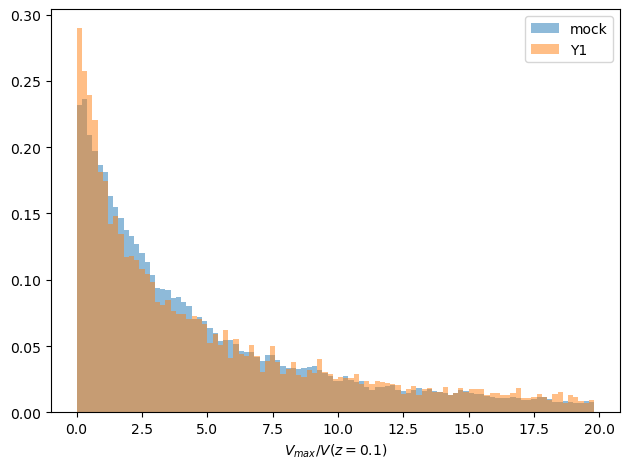

In [34]:
plt.figure(tight_layout=True)

iron_dist = cosmology.luminosity_distance(np.abs(tfrcat['Z_DESI'].values))
iron_d26kpc = 2*iron_dist.to('kpc') * np.tan(0.5*tfrcat['D26'].values*u.arcmin)
iron_dist_max = 0.5*iron_d26kpc / np.tan(0.1*u.arcmin)

plt.hist(mock['MAX_VOL_FRAC'], np.arange(0, 20, 0.2), density=True, alpha=0.5, label='mock')
plt.hist(iron_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3, np.arange(0, 20, 0.2), density=True, alpha=0.5, label='Y1')

plt.legend()

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

### What is the size distribution of galaxies with $M_r > -17$?

Our usual definition of a dwarf galaxy is to have $M_r > -17$.  Because we don't know this for the data a priori, can we use the galaxy's size as a proxy?

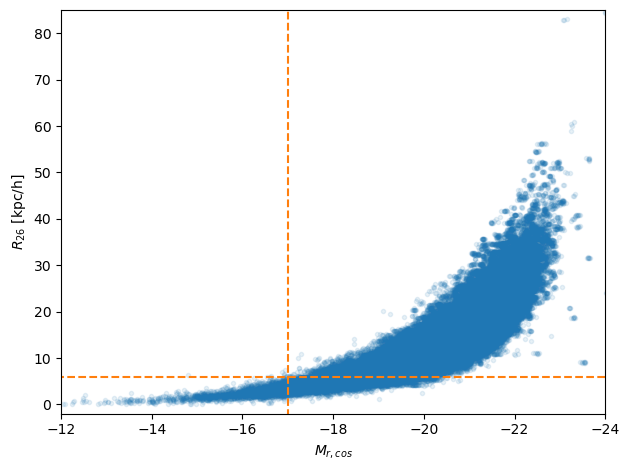

In [35]:
plt.figure(tight_layout=True)

plt.plot(Mr_cos_mock, 0.5*d26_kpc, '.', alpha=0.1)

plt.vlines(-17, -5, 90, colors='tab:orange', linestyles='dashed')
plt.hlines(6, -24, -12, colors='tab:orange', linestyles='dashed')

plt.xlim(-12, -24)
plt.ylim(-2, 85)

plt.xlabel('$M_{r, cos}$')
plt.ylabel('$R_{26}$ [kpc/h]');

### Apply Alex's velocity and dwarf cuts

In [51]:
# Alex's definition for dwarfs
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

Rlim_eff = np.minimum(Rlim, mock['MU_OBS_MOCK'] + Mlim)
mock_dwarfs = mock['R_MAG_SB26'] > Rlim_eff

#### Implement Alex's velocity cuts

In [52]:
# Alex's velocity cuts
logVmin = np.log10(70)
logVmax = np.log10(300)

logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)

logVMmax = np.minimum(logVmax, logVM_slope*(mock['MU_OBS_MOCK'] - logVM_zero) + 2)
mock_goodV = (mock['LOGVROT_MOCK'] > logVmin) & (mock['LOGVROT_MOCK'] < logVmax) & (mock['LOGVROT_MOCK'] < logVMmax)

#### Create a "data" sample with which to fit

In [53]:
def downsample(mock, size=100):
    """Randomly downsample a mock catalog, without replacement, to some size.

    Parameters
    ----------
    mock: pandas.DataFrame
        Pandas table with a mock catalog.
    size: int
        Size of the final downsampled catalog.

    Returns
    -------
    newmock: pandas.DataFrame
        Downsampled Pandas table.
    """
    Nmock = len(mock)
    idx_downsample = np.random.choice(Nmock, size, replace=False)
    return mock.iloc[idx_downsample]

In [54]:
#- Only use non-dwarf galaxies with good velocities
mock_main = ~mock_dwarfs & mock_goodV

Ntfr = 4935 # Number of objects in Y1 that made it through all the calibration cuts
mock_downsample = downsample(mock[mock_main], Ntfr)

### Fit the TFR and Compute Mock Distance Moduli

Fit $M_{r,\mathrm{obs,mock}}$ versus $\log{V_\mathrm{rot,mock}}$ to get a mock TFR.

Then compute the TF distance modulus as

$$
\mu_\mathrm{mock} = m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{obs,mock}},
$$

where the apparent magnitude is the quantity `R_MAG_SB26_CORR` used to compute magnitudes from the cosmological and observed redshift.

In [55]:
# Bin the galaxies
zbin_indices = np.digitize(mock['zobs'], zbins, right=True)
zbin_indices_downsample = np.digitize(mock_downsample['zobs'], zbins, right=True)

In [56]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')

 0  z <= 0.030  382 galaxies
 1  0.030 < z <= 0.035  378 galaxies
 2  0.035 < z <= 0.040  442 galaxies
 3  0.040 < z <= 0.045  472 galaxies
 4  0.045 < z <= 0.050  400 galaxies
 5  0.050 < z <= 0.055  410 galaxies
 6  0.055 < z <= 0.060  334 galaxies
 7  0.060 < z <= 0.065  339 galaxies
 8  0.065 < z <= 0.070  365 galaxies
 9  0.070 < z <= 0.075  277 galaxies
10  0.075 < z <= 0.080  278 galaxies
11  0.080 < z <= 0.085  231 galaxies
12  0.085 < z <= 0.090  195 galaxies
13  0.090 < z <= 0.095  150 galaxies
14  0.095 < z <= 0.100  102 galaxies
15  0.100 < z <= 0.105  101 galaxies
16  z > 0.105   79 galaxies


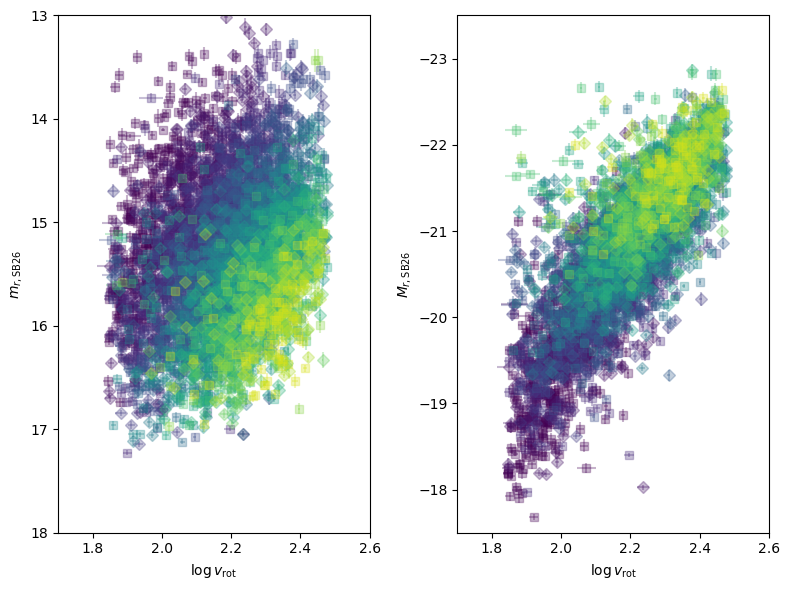

In [57]:
fig, axes = plt.subplots(1,2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

_zbin_ids = np.sort(np.unique(zbin_indices_downsample))
n_zbins = len(_zbin_ids)

markers = 'sDv^<>'

colors = iter(plt.cm.viridis(np.linspace(0,1, n_zbins + 1)))

for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(zbin_indices_downsample, _zbin_id)

    logv = mock_downsample['LOGVROT_MOCK'][select_zbin] - logV0
    logv_err = 0.434*mock_downsample['LOGVROT_ERR_MOCK'][select_zbin] / mock_downsample['LOGVROT_MOCK'][select_zbin]

    mr26 = mock_downsample['R_MAG_SB26_CORR'][select_zbin]
    mr26_err = mock_downsample['R_MAG_SB26_ERR_CORR'][select_zbin]

    Mr26 = mock_downsample['R_ABSMAG_SB26_MOCK'][select_zbin]
    Mr26_err = mock_downsample['R_ABSMAG_SB26_ERR_MOCK'][select_zbin]

    c = next(colors)

    ax = axes[0]
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

    ax = axes[1]
    ax.errorbar(x=logv, y=Mr26, xerr=logv_err, yerr=Mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

ax = axes[0]
ax.set(xlim=(1.7, 2.6),
       ylim=(18, 13),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{SB26}}$')

ax = axes[1]
ax.set(ylim=(-17.5, -23.5),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{SB26}}$');

#### Pack the data for `MultiLinFit`

In [65]:
# Determine logV0 for the test calibration
logV0_mock = np.median(mock_downsample['LOGVROT_MOCK'])
print(logV0_mock)

# Pack the calibration set into lists
logv, dlogv = [], []
mr, dmr = [], []
weights = []

# Loop over the redshift bins
for k in range(1,len(zbins)):

    # Identify objects in this bin
    cal_idx = zbin_indices_downsample == k

    logv.append(mock_downsample['LOGVROT_MOCK'].to_numpy()[cal_idx] - logV0_mock)
    dlogv.append(mock_downsample['LOGVROT_ERR_MOCK'].to_numpy()[cal_idx])
    mr.append(mock_downsample['R_MAG_SB26_CORR'].to_numpy()[cal_idx])
    dmr.append(mock_downsample['R_MAG_SB26_ERR_CORR'].to_numpy()[cal_idx])
    # weights.append(np.ones(np.sum(cal_idx)))
    # weights.append(1/mock_downsample['MAX_VOL_FRAC'].to_numpy()[cal_idx])

2.2008191521077176


#### Fit with `MultiLinFit`

In [67]:
# Number of redshift bins
m = len(logv)

bounds = [[-10, -5]]        # Bounds on a (slope)
bounds += m*[(0, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,2)]          # Bounds on sigma

# logging.warning('Fit does not account for volume weights.')

# results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, weights=weights, scatter=1)
results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, scatter=1)

a_mcmc, b_mcmc, sigma_mcmc, cov_mcmc, mcmc_samples, hf = results

     fun: -3090219.636222807
     jac: array([-3.77185645, -0.9313225 ,  2.23517399,  1.490116  , -0.1862645 ,
        7.26431548, -0.83819025,  0.65192575,  0.97788862, -4.98257536,
       -6.05359623, -2.18860787, 11.82779572, 21.14102069,  6.65895586,
       11.96749409,  5.49480316])
 message: 'Optimization terminated successfully.'
    nfev: 36717
     nit: 142
 success: True
       x: array([-7.41611484, 14.06775501, 14.49165983, 14.77170271, 14.98563978,
       15.31160452, 15.42948632, 15.69094212, 15.8182622 , 15.96162624,
       16.09919051, 16.25343973, 16.32987337, 16.5962271 , 16.57123893,
       16.7425055 ,  0.54622046])
Ndim: 17 15


100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [74.31360053 58.49530559 48.84799229 38.6212406  43.30775933 34.64262263
 48.92955959 52.14540729 41.87918658 61.20627625 66.9258742  54.44631239
 48.79834528 69.1395487  69.39979714 66.09475267 68.79833663] / 3715.6800262924867


100%|██████████| 1000/1000 [00:53<00:00, 18.64it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.47557735 65.90343092 61.71041899 58.99989151 50.00329478 52.19595454
 60.11530431 51.24441552 58.52716666 67.15268632 70.50265776 67.02060478
 72.91875601 79.9998712  85.65341386 92.70518136 87.3557818 ] / 4773.778867589589


100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.3040238   60.29909068  55.23651752  48.49931741  52.38716145
  44.62473667  67.57850542  67.0660559   64.15779269  73.70494111
  64.55190752  72.51560194  79.40413826  77.55682573  91.55223613
  90.36269525  99.95504067] / 5065.201189755495


100%|██████████| 1000/1000 [00:53<00:00, 18.55it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [108.51248213  70.3711906   60.464047    54.10871655  60.75246614
  45.99168704  64.8397388   61.99657374  67.19943101  65.17896757
  71.14053621  79.37039182  90.44100875  89.40554436  95.23318594
 111.81361386 120.4866898 ] / 6024.334489985452


100%|██████████| 1000/1000 [00:53<00:00, 18.57it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.96554289  67.39145628  60.48926749  54.78089264  61.65741003
  44.13159505  58.69113126  60.38463313  60.32350491  63.75950607
  75.99588905  79.94147142  86.7832781   90.64293672 105.72816233
 116.69218768 138.71345831] / 6935.672915695193


100%|██████████| 1000/1000 [00:53<00:00, 18.56it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [119.18172689  70.24783751  64.58551599  54.18642826  70.76024147
  47.72964648  62.57648831  64.92505366  62.37990497  70.28560094
  76.04187862  79.53079666  87.45135579 101.28025199 113.76068799
 139.61947252 140.07790063] / 7003.895031613297


100%|██████████| 1000/1000 [00:54<00:00, 18.50it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.60572676  72.32321448  60.45600854  54.52700844  69.96806676
  47.38833954  61.96318388  62.16749426  63.18580325  76.82356601
  71.67600909  70.75183725  82.79934139 104.47698517 119.83095871
 142.93686225 149.95191457] / 7497.595728475742


100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.32375473  72.81059035  61.97484834  54.16583173  70.68863677
  51.57016418  66.44143234  69.10228611  66.3995035   84.21520622
  76.99957859  75.04753181  82.83329004 102.91807222 148.76512466
 142.61381462 158.40896912] / 7920.448456172946


100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.97222878  70.97054687  66.63317973  54.63087772  69.15370846
  49.09574183  63.03627741  71.45852254  62.59343253  86.64956802
  77.84765675  75.25341433  79.65955038 103.77084177 148.82272746
 145.48353454 155.49364846] / 7848.611438926567


100%|██████████| 1000/1000 [00:53<00:00, 18.52it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [164.81789547  71.73998236  69.0090794   54.82130389  67.83040662
  50.65553317  63.59386977  75.34182111  60.79183255  97.0905671
  79.42933916  78.97535447  79.70593066 105.68270241 153.46612282
 145.44376714 165.29945477] / 8264.972738477874


100%|██████████| 1000/1000 [00:54<00:00, 18.47it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [159.89120851  69.40752795  66.13034227  59.46875337  68.19681867
  49.58249522  64.2232657   75.58888602  64.38057671  94.60999892
  82.06460374  78.76379192  84.80399317 107.21753101 143.226686
 137.69166027 167.1288617 ] / 8356.44308515782


100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [171.71197494  72.56953964  66.7286915   61.0449287   68.27412912
  51.29151874  66.32683863  75.61378666  66.17313851  95.55891826
  84.40824801  79.56120206  87.01309501 105.91454978 143.59507737
 142.16065803 171.84254067] / 8592.127033672805


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [178.64116063  72.19472858  61.88445041  58.63249433  62.5914458
  50.46699178  67.2536404   73.96026781  68.71297691  87.63182915
  90.28393736  82.99763935  93.55965881 109.35878564 141.06029208
 148.3826931  167.98326639] / 8932.058031744213


100%|██████████| 1000/1000 [00:53<00:00, 18.56it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [167.06671613  68.05982325  62.96394867  57.27241864  63.75519173
  51.04728624  66.78752987  76.84153     69.62937452  80.65211523
  92.44876688  87.98650234  97.44835414 108.27319388 147.45597712
 142.45355463 165.59561026] / 8353.33580629118


100%|██████████| 1000/1000 [00:53<00:00, 18.56it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [186.27674381  68.58745435  60.58192164  56.79552287  64.51955841
  51.23985889  66.12612444  77.43417371  68.63900933  86.13355949
  93.5398984   87.3551347   99.11097554 105.42624671 149.28079681
 142.50348641 167.85351641] / 9313.837190545048


100%|██████████| 1000/1000 [00:53<00:00, 18.57it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [158.43442251  69.54913162  63.84649661  57.68880495  67.57578946
  52.23272486  66.42519078  77.33452677  69.08722986  93.28126893
  89.17607926  85.87707849  98.37896431 111.10271926 147.71719344
 141.60228577 160.35818864] / 8017.909432204911


100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [163.57114826  68.82865161  62.56396733  60.00678612  67.81527146
  51.04156301  66.26353668  77.83730376  71.5930812   90.65328507
  87.58249463  88.48496976  98.48132217 111.08373504 154.12088982
 139.78924707 159.36824491] / 8178.557412847928


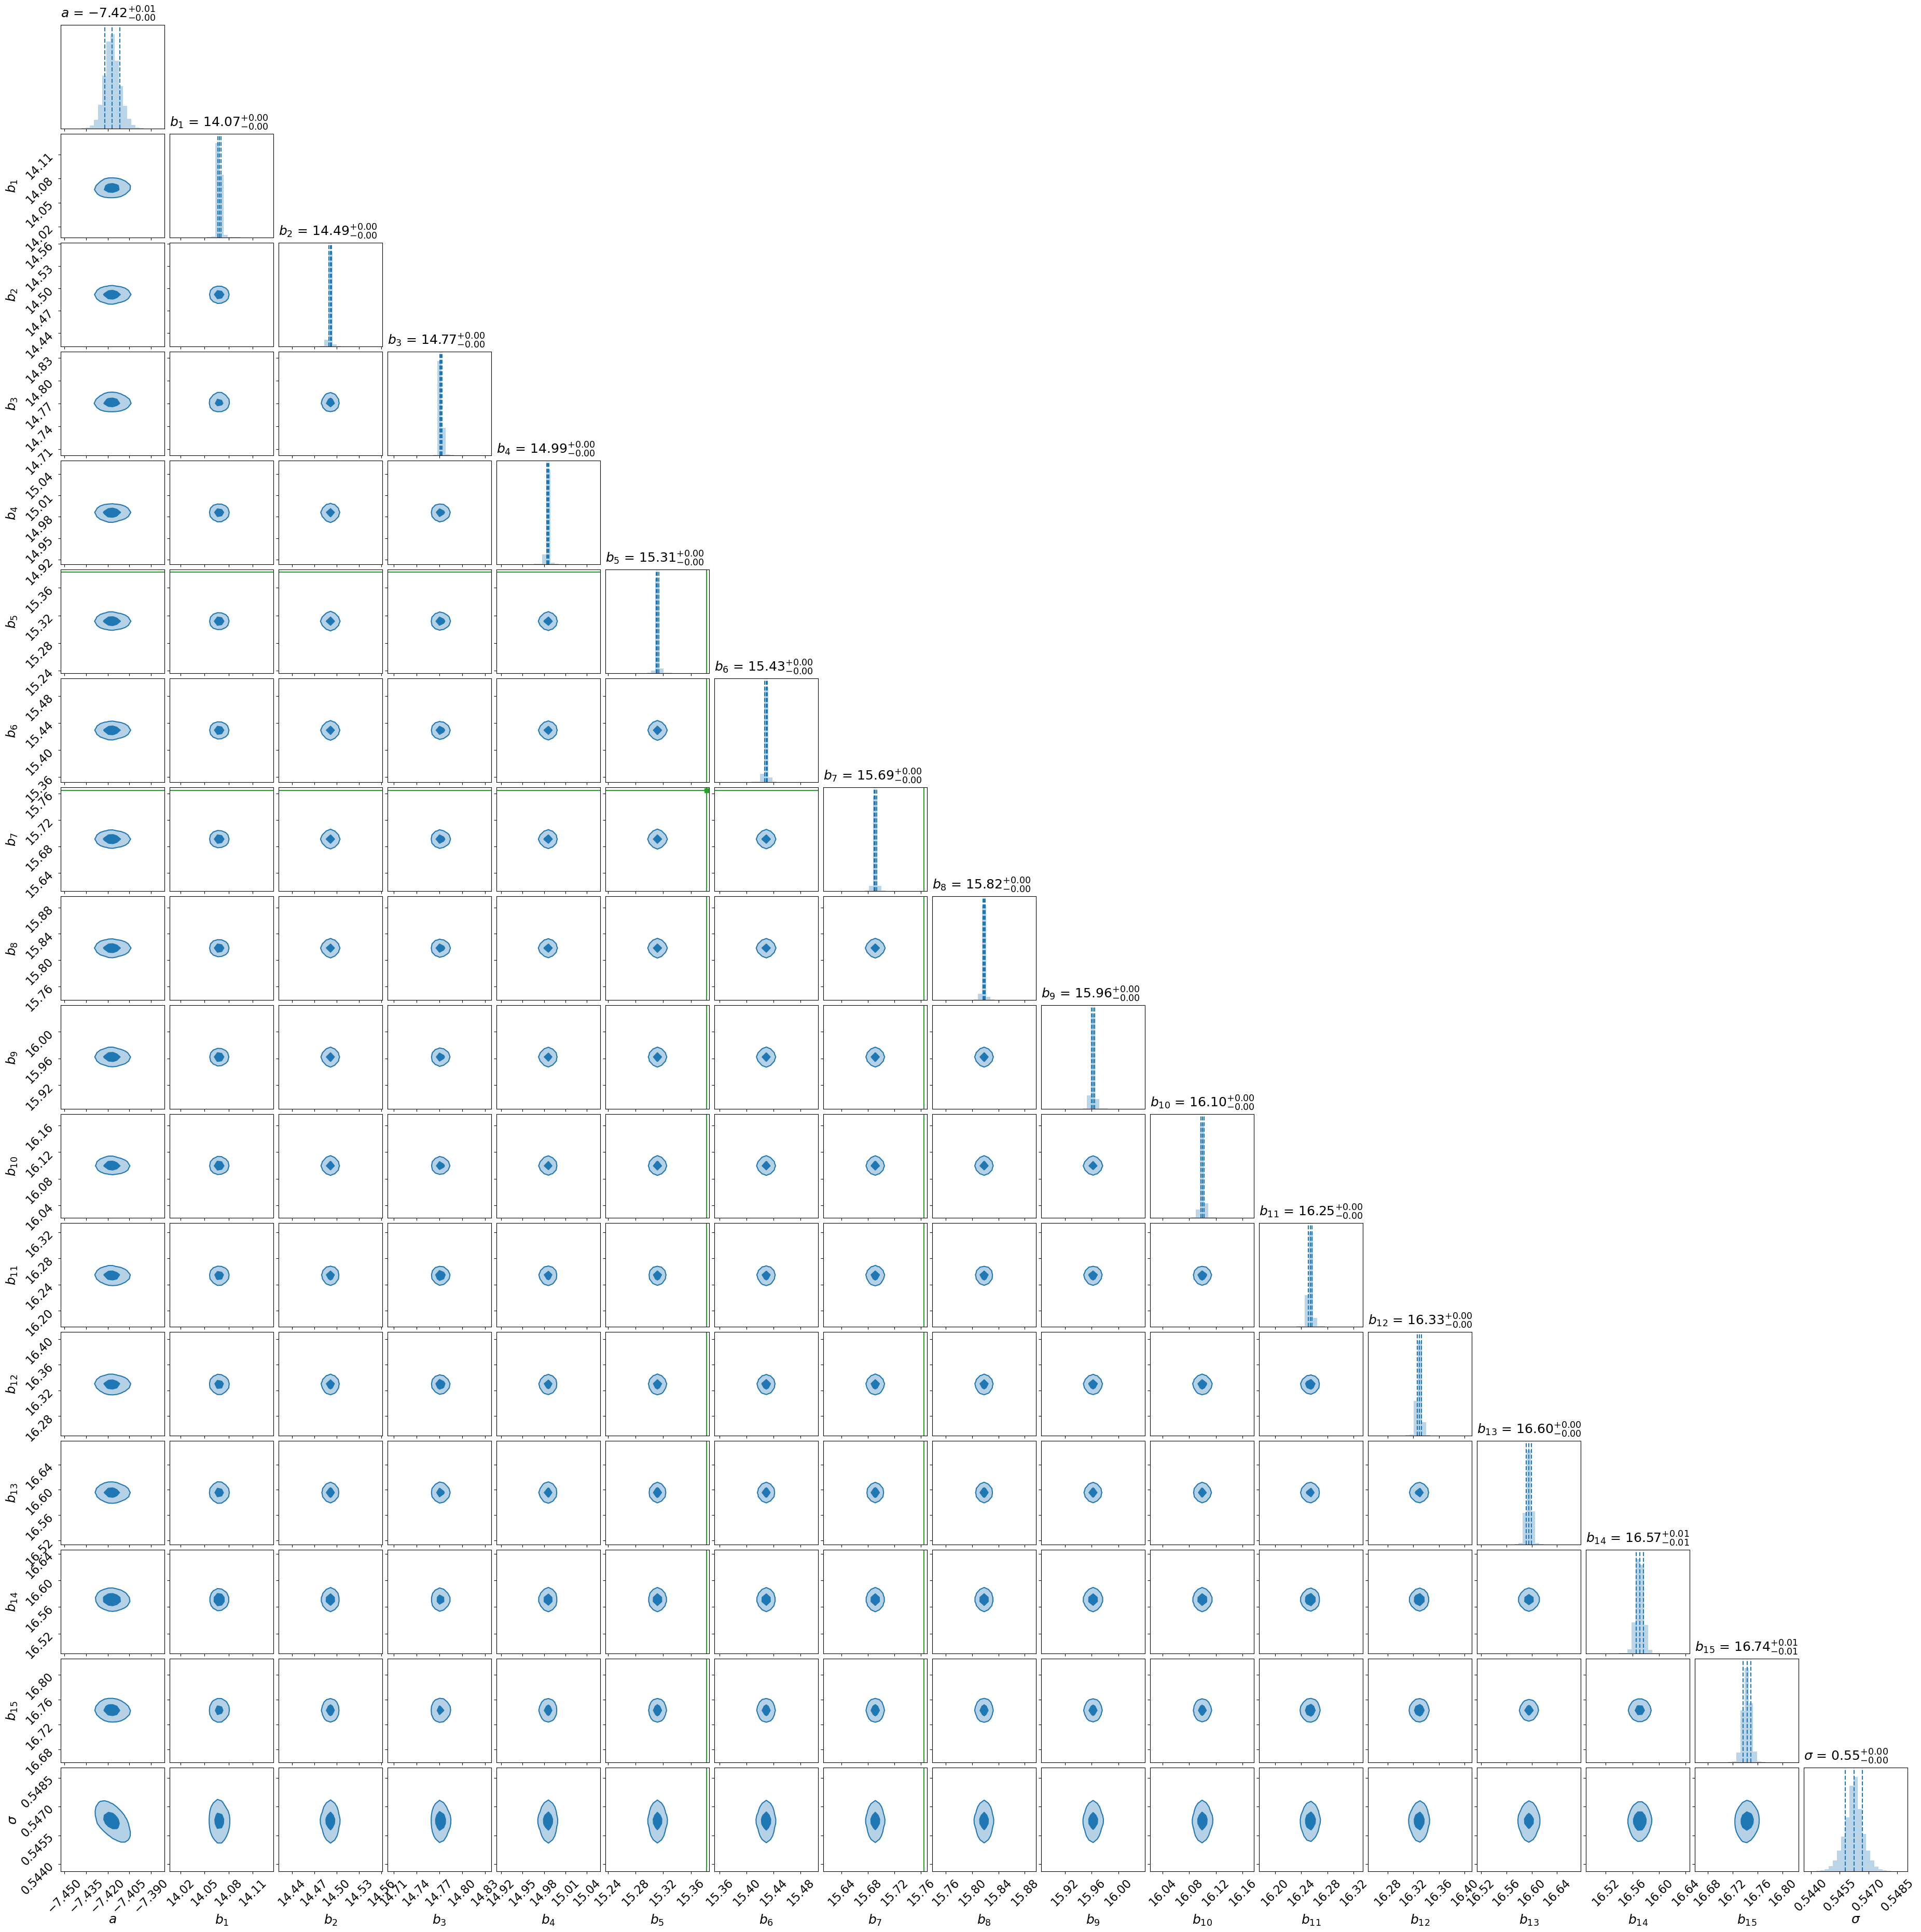

In [68]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(mcmc_samples.T, bins=25, smooth=1,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             truths=tf_par,
             truth_color='tab:green',
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16);

# fig.savefig('tfr_mock_calibration_mcmc.png', dpi=150)

In [69]:
tf_par

array([-7.20176565, 14.39441625, 14.70989495, 14.9373865 , 15.16461899,
       15.38282027, 15.58256514, 15.76429503, 15.9358268 , 16.07575333,
       16.23118681, 16.40326623, 16.52451628, 16.74717343, 16.91192428,
       16.85607594,  0.46511205])

In [70]:
a_mcmc, b_mcmc, sigma_mcmc

(-7.417028768440662,
 array([14.06813861, 14.49146907, 14.77189695, 14.98556979, 15.31170581,
        15.42919335, 15.69094479, 15.8180845 , 15.96197983, 16.0995634 ,
        16.25386794, 16.32941108, 16.59568082, 16.57112686, 16.74300161]),
 array([0.54624916]))

#### Quick Check of Many Realizations of the "Calibration" Sample

In [35]:
N = len(logvrot_mock)
Ns = 150

a_real, b_real, sigma_real = [], [], []

for i in tqdm(np.arange(100)):
    idx = np.random.choice(N-1, size=Ns, replace=False)

    logV0_mock = np.median(logvrot_mock)

    logv  = logvrot_mock[idx] - logV0_mock
    dlogv = logvrot_err_mock[idx]
    Mr  = Mr_obs_mock[idx]
    dMr = Mr_obs_err_mock[idx]
    weights = np.ones_like(logv)
    # weights = 1/mock['MAX_VOL_FRAC'].to_numpy()[idx]
    
    mock_dat = np.empty((2, Ns))
    mock_cov = np.empty((2, 2, Ns))
    
    logv, Ns, len(logv)
    
    for k in range(Ns):
        mock_dat[:, k] = np.array([logv[k], Mr[k]])
        mock_cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dMr[k]**2]])
    
    bounds = [[-20, 0]]                    # Bounds on a (slope)
    bounds += [(-40,0)]                    # Bounds on b (intercepts: 0-pt + clusters)
    bounds += [(0,5)]                      # Bounds on sigma
    
    # logging.warning('Fit does not account for volume weights.')
    
    hf = LinFit(mock_dat, mock_cov, weights=weights)
    (a_bf, b_bf), sigma_bf, ll_bf = hf.optimize(bounds, verbose=False)

    a_real.append(a_bf)
    b_real.append(b_bf),
    sigma_real.append(sigma_bf)
    
    # print(f'a = {a_bf:.3f}')
    # print(f'b = {b_bf:.3f}')
    # print(f'sigma = {sigma_bf:.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'LinFit' is not defined

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

ax = axes[0]
ax.hist(a_real, bins=np.arange(-12.5,-2.4,0.4))
ax.axvline(tf_par[0], color='tab:orange', ls='--')
ax.axvline(np.mean(a_real), color='tab:green')
ax.axvline(np.mean(a_real) - np.std(a_real), color='tab:green', ls='--')
ax.axvline(np.mean(a_real) + np.std(a_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{a}}={np.mean(a_real):.2f}\pm{np.std(a_real):.2f}$',
       xlabel=r'slope $a$')

ax = axes[1]
ax.hist(b_real, bins=np.arange(-21.2,-19.95,0.05))
ax.axvline(tf_par[1], color='tab:orange', ls='--')
ax.axvline(np.mean(b_real), color='tab:green')
ax.axvline(np.mean(b_real) - np.std(b_real), color='tab:green', ls='--')
ax.axvline(np.mean(b_real) + np.std(b_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{b}}={np.mean(b_real):.2f}\pm{np.std(b_real):.2f}$',
       xlabel=r'zero point $b_\mathrm{0pt}$')

ax = axes[2]
ax.hist(sigma_real, bins=np.arange(-0.1,1.45,0.05))
ax.axvline(tf_par[2], color='tab:orange', ls='--')
ax.axvline(np.mean(sigma_real), color='tab:green')
ax.axvline(np.mean(sigma_real) - np.std(sigma_real), color='tab:green', ls='--')
ax.axvline(np.mean(sigma_real) + np.std(sigma_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{\sigma}}={np.mean(sigma_real):.2f}\pm{np.std(sigma_real):.2f}$',
       xlabel=r'magnitude scatter $\sigma$');

# fig.savefig(f'tfr_fit_param_spread_equal_weight_{os.path.basename(mockfile)[:-9]}.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_error_weighted.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_var_weighted.png', dpi=150)

In [ ]:
tf_par

In [ ]:
a_avg = np.average(a_real)
b_avg = np.average(b_real)
sigma_avg = np.average(sigma_real)
a_avg, b_avg, sigma_avg

In [ ]:
a_mcmc, b_mcmc, sigma_mcmc = a_avg, b_avg, sigma_avg

#### Dwarf Cut

In [71]:
#- Apply dwarf cut using galaxy size
mock['DWARF'] = mock_dwarfs

mock['MAIN'] = mock_main

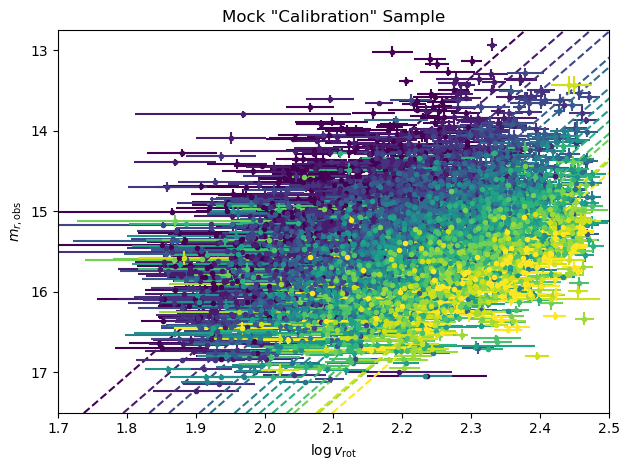

In [72]:
plt.figure(tight_layout=True)

_logv = np.arange(0, 3.1, 0.1)

color = iter(plt.cm.viridis(np.linspace(0,1,m)))
for k in range(m):
    c = next(color)
    plt.errorbar(logv[k] + logV0_mock, mr[k], 
                 xerr=dlogv[k], 
                 yerr=dmr[k], 
                 fmt='.', 
                 c=c)
    plt.plot(_logv, a_mcmc*(_logv - logV0_mock) + b_mcmc[k], color=c, ls='--')

plt.xlim(1.7, 2.5)
plt.ylim(17.5, 12.75)
plt.xlabel(r'$\log{v_\mathrm{rot}}$')
plt.ylabel(r'$m_{r,\mathrm{obs}}$')
plt.title(r'Mock "Calibration" Sample');

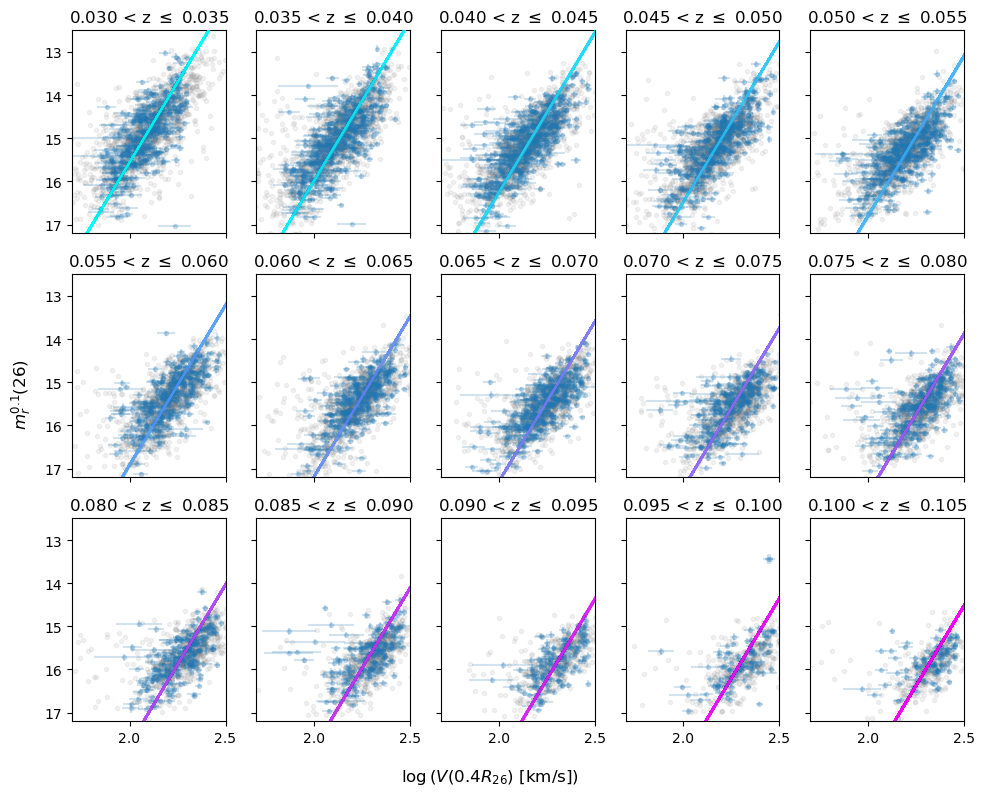

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

_logv = np.arange(0, 3.1, 0.5)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)

    row = int(i/5)
    col = i%5

    axes[row,col].plot(mock['LOGVROT_MOCK'][zbin_indices == i + 1][::10], 
                       mock['R_MAG_SB26_CORR'][zbin_indices == i + 1][::10], 
                       '.', c='gray', alpha=0.1)
    
    axes[row,col].errorbar(logv[i] + logV0_mock, mr[i], 
                           xerr=dlogv[i], 
                           yerr=dmr[i], 
                           fmt='.', 
                           c='tab:blue', 
                           alpha=0.2)

    for (_a, _b) in mcmc_samples[[0,i+1], ::500].T:
        axes[row,col].plot(_logv, _a*(_logv - logV0_mock) + _b, color=c, alpha=0.05, zorder=100)

    axes[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')


fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Compute TFR Distance Modulus

Using the "measured" apparent magnitude and the TFR-predicted absolute magnitude from the "calibration" above, compute the distance modulus:

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

Also compute the log distance ratio

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

In [75]:
#- Compute TF absolute magnitude and uncertainties using the MCMC from HyperFit.
#  Downsample the MCMC significantly for this quick calculation.

#-------------------------------------------------------------------------------
#- First, calculate the distance modulus for each redshift bin
#-------------------------------------------------------------------------------
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmology.distmod(zc)
#-------------------------------------------------------------------------------
#- Then, convert each redshift bin's y-intercept to an absolute magnitude
#-------------------------------------------------------------------------------
B_mcmc = b_mcmc - mu_zc.value
#-------------------------------------------------------------------------------

B_indices = zbin_indices - 1
# For those galaxies that fall outside the calibration range, assign them to the closest bin
B_indices[zbin_indices == 0] = 0
B_indices[zbin_indices == len(zbins)] = len(zbins) - 2

Mr_TF = a_mcmc * (mock['LOGVROT_MOCK'] - logV0_mock) + B_mcmc[B_indices]

# This method takes up too much memory, and the uncertainties on the parameters 
# are subdominant to the scatter and velocity uncertainties anyway
# a_sampled, B_sampled = mcmc_samples[0][::500], mcmc_samples[B_indices][::500] - mu_zc[B_indices, np.newaxis].value
# Mr_TF_err = np.std(a_sampled * (logvrot_mock[:, np.newaxis] - logV0_mock) + B_sampled, axis=1)
rng = np.random.default_rng()
Mr_TF_err = np.zeros(len(mock))
for i in range(len(mock)):
    logv_random = rng.normal(logvrot_mock[i], 0.434*logvrot_err_mock[i], size=1000)
    Mr_stat = a_mcmc*(logv_random - logV0_mock) + B_mcmc[B_indices[i]]
    Mr_TF_err[i] = np.sqrt(np.nanstd(Mr_stat)**2 + sigma_mcmc**2)

mu_TF = mock['R_MAG_SB26_CORR'] - Mr_TF
mu_TF_err = np.sqrt(mock['R_ABSMAG_SB26_ERR_MOCK']**2 + Mr_TF_err**2)

mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)
eta_mock = 0.2 * (mu_zcmb - mu_TF)
eta_err_mock = 0.2 * mu_TF_err

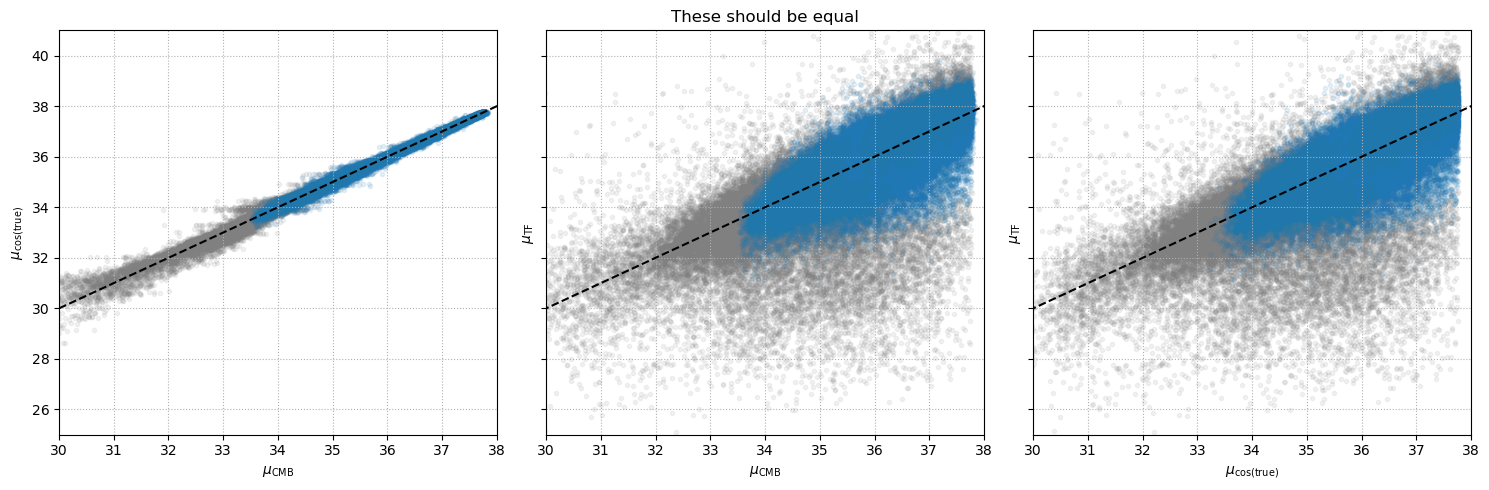

In [76]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), tight_layout=True, sharex=True, sharey=True)


axes[0].plot(mu_zcmb[~mock_main], mu_zcos[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
axes[0].plot(mu_zcmb[mock_main], mu_zcos[mock_main], '.', alpha=0.1, zorder=1)
axes[0].plot([22, 42], [22, 42], 'k--')
axes[0].grid(ls=':')
axes[0].set(#xlim=[30, 38], 
            #ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{cos (true)}$', 
            xlabel=r'$\mu_\mathrm{CMB}$')


axes[1].plot(mu_zcmb[~mock_main], mu_TF[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
axes[1].plot(mu_zcmb[mock_main], mu_TF[mock_main], '.', alpha=0.1, zorder=1)
axes[1].plot([22, 42], [22, 42], 'k--')
axes[1].grid(ls=':')
axes[1].set(#xlim=[30, 38], 
            #ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{CMB}$', 
            title='These should be equal')

axes[2].plot(mu_zcos[~mock_main], mu_TF[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
axes[2].plot(mu_zcos[mock_main], mu_TF[mock_main], '.', alpha=0.1, zorder=1)
axes[2].plot([22, 42], [22, 42], 'k--')
axes[2].grid(ls=':')
axes[2].set(xlim=[30, 38], 
            ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{cos (true)}$');

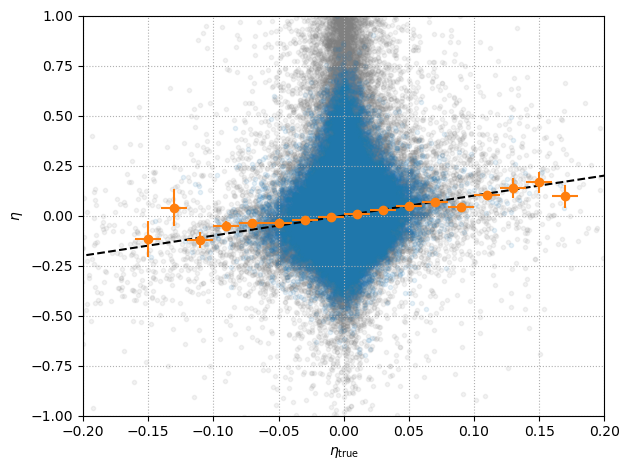

In [77]:
plt.figure(tight_layout=True)

plt.plot(eta_true[~mock_main], eta_mock[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
plt.plot(eta_true[mock_main], eta_mock[mock_main], '.', alpha=0.1, zorder=1)
# plt.hexbin(eta_true, eta_mock, gridsize=1000, bins='log')

plt.plot([-5, 2], [-5, 2], 'k--')

eta_bins = np.arange(-0.5, 0.3, 0.02)
d_eta = 0.5*np.diff(eta_bins)
eta_c = 0.5*(eta_bins[1:] + eta_bins[:-1])

_, eta_avg, eta_std = profile_histogram(eta_true[mock_main], eta_mock[mock_main], eta_bins, median=True)
plt.errorbar(eta_c, eta_avg, xerr=d_eta, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

plt.grid(ls=':')

plt.xlim([-0.2, 0.2])
plt.ylim([-1, 1])

plt.xlabel(r'$\eta_\mathrm{true}$')
plt.ylabel(r'$\eta$');

/tmp/ipykernel_1832447/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1832447/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


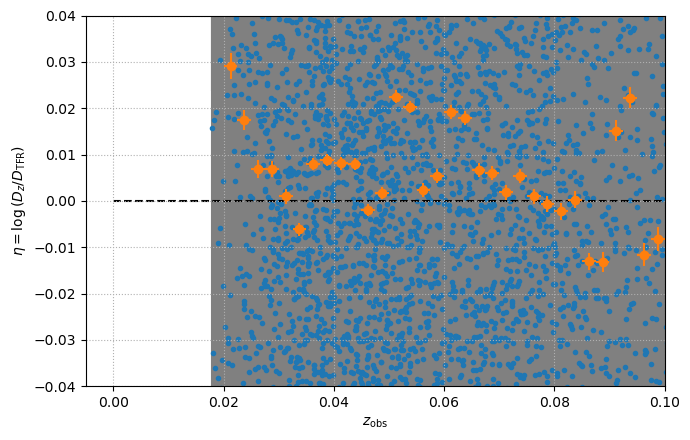

In [78]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5), tight_layout=True)

ax.errorbar(mock['zobs'][mock_main][::20], eta_mock[mock_main][::20],
            yerr=eta_err_mock[mock_main][::20],
            fmt='.',
            # alpha=0.1,
            ecolor='gray', 
            zorder=0)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_mock[mock_main], 
                                        zbins, weights=eta_err_mock[mock_main]**-2, weighted=True)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=1)
ax.grid(ls=':')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$');

# fig.savefig('tfr_mock_eta.png', dpi=150);

/tmp/ipykernel_1832447/497888321.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


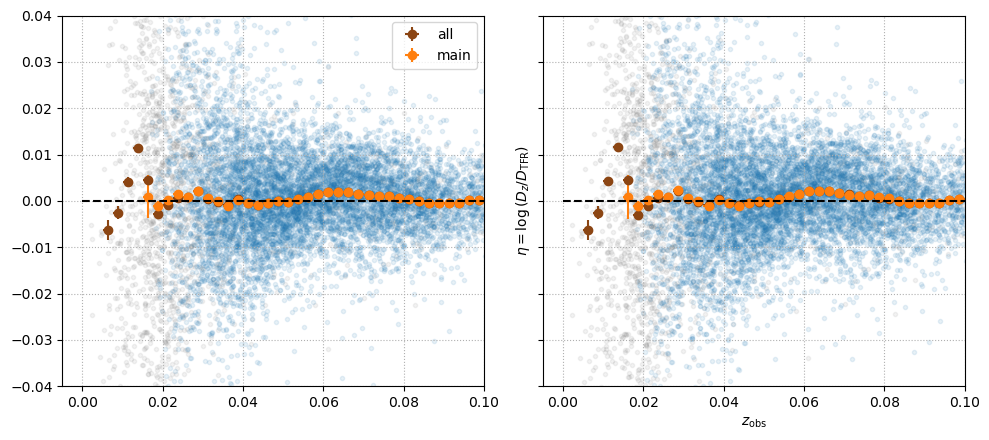

In [79]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'][~mock_main][::20], logdist_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], logdist_true[mock_main][::20], 
           marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'][~mock_main][::20], eta_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], eta_true[mock_main][::20], 
           marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], logdist_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)
ax.grid(ls=':')

ax.legend()

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

/tmp/ipykernel_1832447/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1832447/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


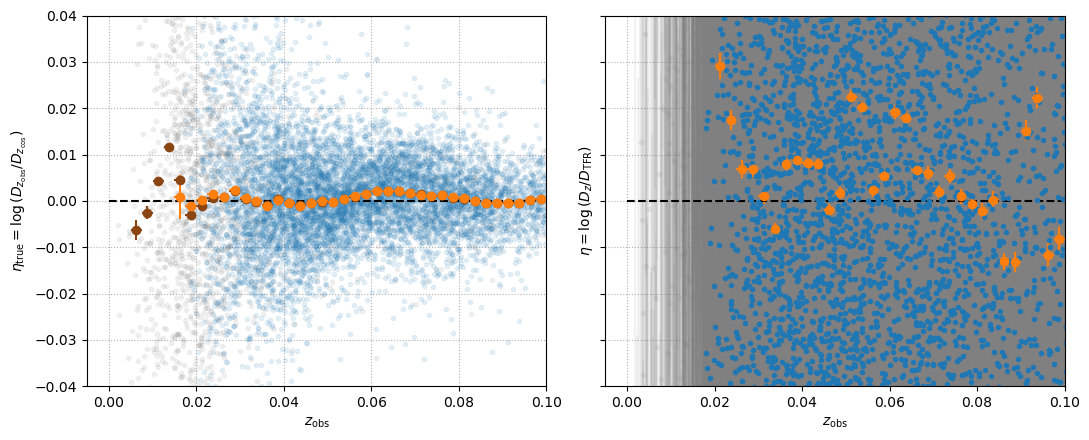

In [80]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.plot(mock['zobs'][~mock_main][::20], eta_true[~mock_main][::20], '.', alpha=0.1, c='gray')
ax.plot(mock['zobs'][mock_main][::20], eta_true[mock_main][::20], '.', alpha=0.1)

ax = axes[1]
ax.errorbar(mock['zobs'][~mock_main][::20], eta_mock[~mock_main][::20], 
            yerr=eta_err_mock[~mock_main][::20], 
            fmt='.', color='gray', alpha=0.1)
ax.errorbar(mock['zobs'][mock_main][::20], eta_mock[mock_main][::20], 
            yerr=eta_err_mock[mock_main][::20], 
            fmt='.', ecolor='gray')

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       # xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} = \log{(D_{z_\mathrm{obs}} / D_{z_\mathrm{cos}})}$')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_mock[mock_main], 
                                        zbins, weights=eta_err_mock[mock_main]**-2, weighted=True)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

# fig.savefig('tfr_mock_eta_true_mock.png', dpi=150);

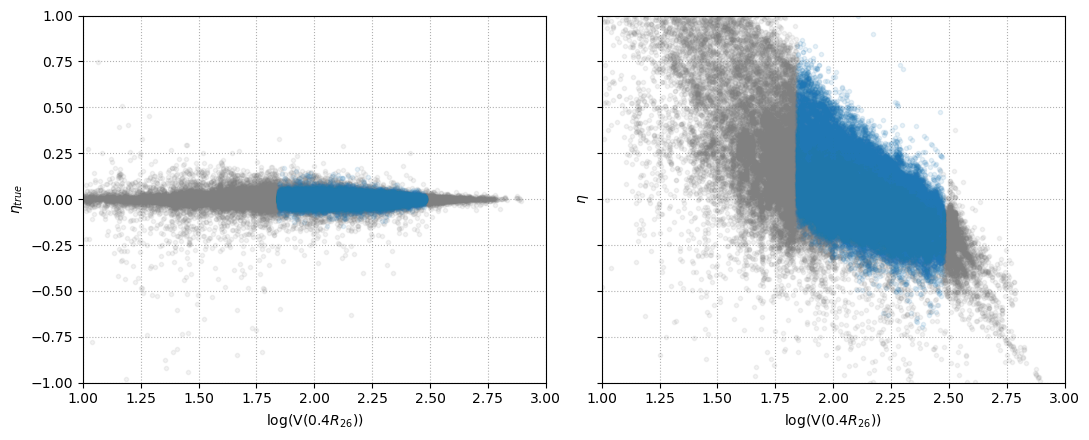

In [83]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

# Truth
ax = axes[0]
ax.plot(logvrot_mock[~mock_main], eta_true[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_true[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta_{true}$', 
       ylim=(-1, 1), 
       xlim=(1,3))


# Mock (generated)
ax = axes[1]
ax.plot(logvrot_mock[~mock_main], eta_mock[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_mock[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta$');

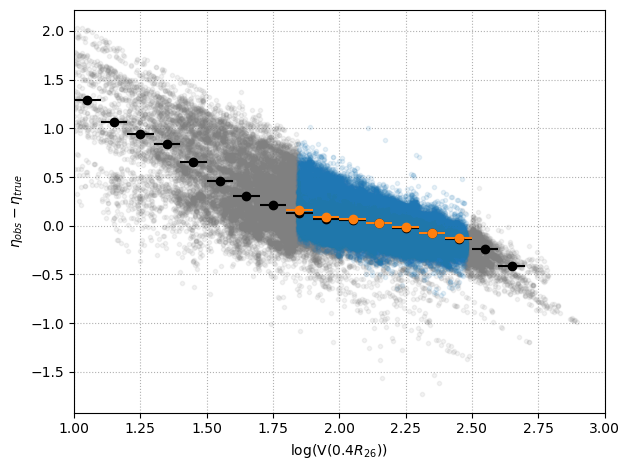

In [85]:
logv_bins = np.arange(1, 2.75, 0.1)
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.plot(logvrot_mock[~mock_main], 
         eta_mock[~mock_main] - eta_true[~mock_main], 
         '.', c='gray', alpha=0.1)

plt.plot(logvrot_mock[mock_main], 
         eta_mock[mock_main] - eta_true[mock_main], 
         '.', c='tab:blue', alpha=0.1)

_, dn_avg, dn_std = profile_histogram(logvrot_mock, eta_mock - eta_true, logv_bins, median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='black')

_, dn_avg, dn_std = profile_histogram(logvrot_mock[mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      logv_bins, 
                                      median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='tab:orange')

plt.grid(ls=':')

plt.xlim((1,3))

plt.xlabel('log(V(0.4$R_{26}$))')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

## Write Output to FITS

In [34]:
outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5',
                       os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))

hdr = fits.Header(dict(NTF=len(mock),
                       a=a_mcmc,
                       b=b_mcmc,
                       sigma=sigma_mcmc,
                       cov_aa=cov_mcmc[0][0],
                       cov_ab=cov_mcmc[0][1],
                       cov_as=cov_mcmc[0][2],
                       cov_bb=cov_mcmc[1][1],
                       cov_bs=cov_mcmc[1][2],
                       cov_ss=cov_mcmc[2][2]))

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['DWARF'].to_numpy())
col09 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col10 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col11 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col12 = fits.Column(name='LOGDIST',       format='D', array=eta_mock.to_numpy())
col13 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock.to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13], header=hdr)
hdulist.writeto(outfile, overwrite=True)

shutil.chown(outfile, group='desi')